#importing data and transforming

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
num_workers=0#no parallelism on multiple processors
batch_size=20
transform=transforms.ToTensor()
train_data=datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)
test_data=datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)
train_loader=torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers

)
test_loader=torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers
)

100%|██████████| 9912422/9912422 [00:00<00:00, 251810712.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 146122670.48it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71069985.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23548243.22it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#1. The shared conv layer

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class convlayer(nn.Module):
  def __init__(self,in_channels=1,out_channels=256):
      super(convlayer,self).__init__()
      self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=9,stride=1,padding=0)

  def forward(self,x):
    output=F.relu(self.conv(x))
    return output

#reshape to convert the outputs to vectors

In [4]:
class primarycapsule(nn.Module):
  def __init__(self,num_capsules=8,in_channels=256,out_channels=32):
    super(primarycapsule,self).__init__()
    self.capsules=nn.ModuleList([
        #capsule ka khudka filter jo ki learnable hai
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=9
                  ,stride=2,padding=0)
        for _ in range(num_capsules)
    ])

  def forward(self,x):
    #pass one batch at time
    batch_size=x.size(0)
    #reshape conv output to be (batch_size,vector_dim=1152,1)
    u=[capsule(x).view(batch_size,32*6*6,1) for capsule in self.capsules]#basically ye line 1152 vector outputs banari hai from the conv output
    #stack up output vectors ,u,one for each capsule
    #jo har capsule ke filter se responses mile hai unko stack up krdenge
    u=torch.cat(u,dim=-1)
    #squash krlo to normalise
    u_squash=self.squash(u)
    return u_squash

  def squash(self,input_tensor):
    '''Squashes an input Tensor so it has a magnitude between 0-1.
               param input_tensor: a stack of capsule inputs, s_j
               return: a stack of normalized, capsule output vectors, v_j
               '''
    squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
    scale = squared_norm / (1 + squared_norm) # normalization coeff
    output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
    return output_tensor




#detail wala part

In [5]:

def softmax(input_tensor,dim=1):
  transposed_input=input_tensor.transpose(dim,len(input_tensor.size())-1)
  softmaxed_output=F.softmax(transposed_input.contiguous().view(-1,transposed_input.size(-1)),dim=-1)
  #untransposed result
  return softmaxed_output.view(*transposed_input.size()).transpose(dim,len(input_tensor.size())-1)

1.c_ij: These are the coupling coefficients obtained by applying softmax to the initial routing weights b_ij. Each entry c_ij[i, j] represents the probability that capsule i in the higher layer should be coupled to capsule j in the lower layer.

2.u_hat: This is the input, which consists of the weighted capsule vectors W u. Each capsule in the lower layer has an associated vector of predictions, and these vectors are weighted by W, which is a learnable weight matrix. So u_hat represents the weighted predictions from the lower layer capsules for each capsule in the higher layer.(this is the stacked up tensor,basically complete vector space jisme vector of prediciotns hain)

3.(c_ij * u_hat): This element-wise multiplication combines the coupling coefficients with the weighted predictions. Essentially, it's calculating the contribution of each capsule in the lower layer to each capsule in the higher layer.


In [6]:
#pichla paragraph is the backbone of dynamic routing
#dynamic routing code
#u_hat is the stacked up tensor
#bij is the initial routing weight(basically initial routing probablity)
#start me routing weight is set to 0,means higher layer capsules equal i/p recieve krenge initially.
#This means that capsules in the higher layer initially receive equal contributions from capsules in the lower layer
def dynamic_routing(b_ij,u_hat,squash,routing_iterations=3):

  for iteration in range(routing_iterations):
    #bij is initial routing cost coupling i and j capsules
    c_ij=softmax(b_ij,dim=2)
    #(weighted sum),u-hat = vector space of predictions, multiplied with the current routing weights
    #jo agree krre honge vectors , unka weighted sum automatically zyada hi ayga
    #You compute s_j based on these routing probabilities. s_j is essentially the sum of the contributions of the lower-layer capsules to capsule j.
    s_j=(c_ij*u_hat).sum(dim=2,keepdim=True)
    #squash krdo (normalise)
    v_j=squash(s_j)
    ##see ppt for best explanation
    if iteration < routing_iterations -1:
      #agreement between lower level and higher level capsule
      #You calculate a_ij, which quantifies how well the predictions of the lower-layer capsules match the output of capsule j.
      #we see the agreeing capule proba vectors in u_hat and v_j
      a_ij=(u_hat*v_j).sum(dim=-1,keepdim=True)
      #routing probablity weights ko update bhi krna hai,weighted sum ke equal hi increase hoga
      b_ij=b_ij + a_ij

    return v_j

ab digit capsules banaynge, each capsule corresponding to a digit between 0 and 9

In [7]:
#total 10 capsule banenge, 1 for each digit
class digitcaps(nn.Module):
  def __init__(self,num_capsules=10,previous_layer_nodes=32*6*6,in_channels=8,out_channels=16):
    super(digitcaps,self).__init__()
    # setting class variables
    self.num_capsules = num_capsules
    self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
    self.in_channels = in_channels # previous layer's number of capsules
    #routing probablity basically contribution nikalra hai current capsule ka
    #next capsule ke output me
    #however the routing prob weights dont tell the capsule network how to transfer
    #the input capsule vector to the output capsule vector
    #this is done through this weight matrix
    #this is learnable
    self.W=nn.Parameter(torch.randn(num_capsules,previous_layer_nodes,in_channels,out_channels))

  def forward(self, u):
          '''Defines the feedforward behavior.
            param u: the input; vectors from the previous PrimaryCaps layer
            return: a set of normalized, capsule output vectors
            '''

          # adding batch_size dims and stacking all u vectors
          u = u[None, :, :, None, :]
          # 4D weight matrix
          W = self.W[:, None, :, :, :]

          # calculating u_hat = W*u
          u_hat = torch.matmul(u, W)

          # getting the correct size of b_ij
          # setting them all to 0, initially
          b_ij = torch.zeros(*u_hat.size())

          # update coupling coefficients and calculate v_j
          v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

          return v_j # return final vector outputs

  def squash(self, input_tensor):
          '''Squashes an input Tensor so it has a magnitude between 0-1.
            param input_tensor: a stack of capsule inputs, s_j
            return: a stack of normalized, capsule output vectors, v_j
            '''
          # same squash function as before
          squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
          scale = squared_norm / (1 + squared_norm) # normalization coeff
          output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
          return output_tensor





Decoder-some fcls, we can train and test without decoder too

In [8]:
#decoder basically reconstructs the image, it helps in better training process
class decoder(nn.Module):
  #input is the output from the digit caps layer, (it is a 10d vector)
  #each dimension
  def __init__(self,input_vector_length=16,input_capsules=10,hidden_dim=512):
     '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
     super(decoder,self).__init__()

      #total incoming dimension(basically a tensor)
     input_dim=input_vector_length*input_capsules

      #fcls according to paper
     self.linear_layers=nn.Sequential(
         nn.Linear(input_dim,hidden_dim),
         nn.ReLU(inplace=True),
         nn.Linear(hidden_dim,hidden_dim*2),
         nn.ReLU(inplace=True),
         nn.Linear(hidden_dim*2,28*28),#28x28 image
         nn.Sigmoid(),## sigmoid activation to get output pixel values in a range from 0-1
      )
  def forward(self,x):
    #input lega x
    #digit caps layer se incoming vector
    #2 cheeze return krega
    # first. the reconstructed image
    #class scores-y

    #square krne se we give emphasize the capsules that have strong feature represnetation
    #square se kam repres krne wala or kam hojayga and zyada wala or zyda
    #sum krke effective vector miljayga
    #softmax leke corresponding prob
    classes=(x**2).sum(dim=-1)**0.5
    classes = F.softmax(classes, dim=-1)

    #find the capsule with maximum probablity vector length
    _,max_length_indices=classes.max(dim=1)

    #creating a sparse matrix, to calculate class scores
    sparse_matrix=torch.eye(10)
    '''  example of sparse matrix with 10 classes.
    tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # Class 0
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],  # Class 1
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],  # Class 2
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],  # Class 3
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # Class 4
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],  # Class 5
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],  # Class 6
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],  # Class 7
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # Class 8
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # Class 9


    '''
    #max_length_indices contains the index of capsule with maximum length
    y=sparse_matrix.index_select(dim=0,index=max_length_indices.data)

    #lets reconstruct the image(x is the input tensor ,y are the rows we picked up from corresponding max indices from sparse matrix)
    x=x*y[:,:,None]
    #flatten the image into a vector shape(batch_size,vector_dim)
    flattened_x=x.contiguous().view(x.size(0),-1)
    reconstructions=self.linear_layers(flattened_x)

    return reconstructions,y








In [9]:
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
sum_2d = tensor_2d.sum(dim=0)  # Sum along the last dimension (columns)
print(sum_2d)

tensor([5, 7, 9])


lets collect all the layers we have made

In [10]:
class capsulenetwork(nn.Module):
  def __init__(self):
    super(capsulenetwork,self).__init__()
    self.conv_layer=convlayer()#shared conv layer
    self.primary_capsules=primarycapsule()
    self.digit_capsules=digitcaps()
    self.decoder=decoder()
  def forward(self,images):
    #the feedforward behaviour
    primary_caps_output=self.primary_capsules(self.conv_layer(images))
    caps_output=self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
    reconstructions,y=self.decoder(caps_output)
    return caps_output,reconstructions,y

In [11]:
capsule_net=capsulenetwork()
print(capsule_net)

capsulenetwork(
  (conv_layer): convlayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): primarycapsule(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): digitcaps()
  (decoder): decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


In [12]:
#capsnet is weighted comb of two type of losses
#margin loss and reconstruction loss
#rec loss=recons image-orig image
#margin loss=(think of it as cross entropy based on length of output vectors coming from digit caps layer)


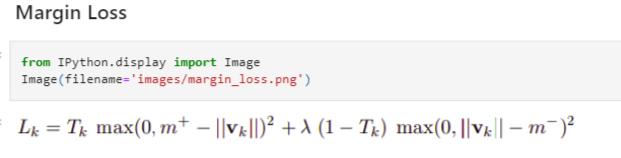![image.png]()

In [19]:
class capsuleloss(nn.Module):
  def __init__(self):
      super(capsuleloss,self).__init__()
      self.reconstruction_loss=nn.MSELoss(reduction='sum')
  def forward(self,x,labels,images,reconstructions):
      batch_size=x.size(0)
      #margin loss
      # get magnitude of digit capsule vectors, v_c
      v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

          # calculate "correct" and incorrect loss
      left = F.relu(0.9 - v_c).view(batch_size, -1)
      right = F.relu(v_c - 0.1).view(batch_size, -1)

          # sum the losses, with a lambda = 0.5
      margin_loss = labels * left + 0.5 * (1. - labels) * right
      margin_loss = margin_loss.sum()

          ##  calculate the reconstruction loss   ##
      images = images.view(reconstructions.size()[0], -1)
      reconstruction_loss = self.reconstruction_loss(reconstructions, images)

          # return a weighted, summed loss, averaged over a batch size
      return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)


loss and training

In [20]:
import torch.optim as optim

# custom loss
criterion = capsuleloss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

In [21]:
def train(capsule_net,criterion,optimizer,n_epochs,print_every=300):
  losses=[]
  for epoch in range(1,n_epochs+1):
    train_loss=0
    #set to train mode
    capsule_net.train()
    #get batches of training image data and targets
    for batch_i,(images,target) in enumerate(train_loader):
      #reshape and get target class
      target=torch.eye(10).index_select(dim=0,index=target)
      optimizer.zero_grad()
      caps_output,reconstructions,y=capsule_net(images)
      loss=criterion(caps_output,target,images,reconstructions)
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()

      #print training stats
      if batch_i!=0 and batch_i %print_every==0:
        avg_train_loss=train_loss/print_every
        losses.append(avg_train_loss)
        print('epoch: {}\tTraining loss:{:.8f}'.format(epoch,avg_train_loss))
        train_loss=0
  return losses


In [23]:
n_epochs=5
losses=train(capsule_net,criterion,optimizer,n_epochs=n_epochs)

epoch: 1	Training loss:0.12228379
epoch: 1	Training loss:0.12002343
epoch: 1	Training loss:0.11857985
epoch: 1	Training loss:0.09796197
epoch: 1	Training loss:0.10055489
epoch: 1	Training loss:0.09307893
epoch: 1	Training loss:0.08876948
epoch: 1	Training loss:0.08709361
epoch: 1	Training loss:0.08528363
epoch: 2	Training loss:0.07078079
epoch: 2	Training loss:0.07331999
epoch: 2	Training loss:0.07450242
epoch: 2	Training loss:0.06612161
epoch: 2	Training loss:0.06947752
epoch: 2	Training loss:0.06608012
epoch: 2	Training loss:0.06545917
epoch: 2	Training loss:0.06513359
epoch: 2	Training loss:0.06372829
epoch: 3	Training loss:0.05606408
epoch: 3	Training loss:0.05799456
epoch: 3	Training loss:0.05809744
epoch: 3	Training loss:0.05289580
epoch: 3	Training loss:0.05583488
epoch: 3	Training loss:0.05335423
epoch: 3	Training loss:0.05367233
epoch: 3	Training loss:0.05388024
epoch: 3	Training loss:0.05261454
epoch: 4	Training loss:0.04737041
epoch: 4	Training loss:0.04886310
epoch: 4	Train

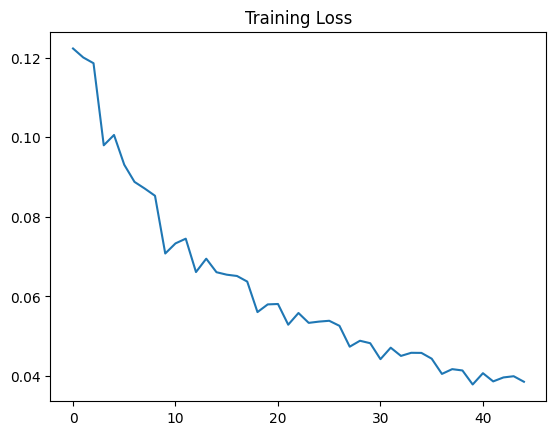

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [25]:
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponding reconstructions
       '''
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    test_loss = 0 # loss tracking

    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)

        batch_size = images.size(0)

        #if TRAIN_ON_GPU:
            #images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        # update average test loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [27]:
import numpy as np

In [28]:
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.05153964

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1132/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 98% (970/982)
Test Accuracy of     5: 99% (887/892)
Test Accuracy of     6: 98% (948/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 98% (961/974)
Test Accuracy of     9: 98% (992/1009)

Test Accuracy (Overall): 99% (9909/10000)
